# 自律移動マリオやってみた

In [27]:
import sys
import os
import random

import gym
import ppaquette_gym_super_mario
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Wrapperの作成

In [3]:
class MaxAndSkipEnv(gym.Wrapper):
    
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        
        return self.env.reset(**kwargs)


class WarpFrame(gym.ObservationWrapper):
    
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs


class ClipRewardEnv(gym.RewardWrapper):
    
    def __init__(self, env):
        
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        
        return np.sign(reward)


class LazyFrames(object):
    
    def __init__(self, frames):
        
        self._frames = frames
        self._out = None

    def _force(self):
        
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        
        return len(self._force())

    def __getitem__(self, i):
        
        return self._force()[i]

    def count(self):
        
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        
        return self._force()[..., i]
    
    
class TorchFrame(gym.ObservationWrapper):
    
    def __init__(self, env):
        
        super().__init__(env)
        height, width, channels = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(channels, height, width),
            dtype=np.uint8,
        )

    def observation(self, obs):
        
        return torch.as_tensor(obs.transpose([2, 0, 1]))

##  環境生成

In [4]:
def make_action(command):
    
    if command == 0:
        return [0, 0, 0, 1, 0, 0]
    elif command == 1:
        return [0, 0, 0, 1, 1, 0]

In [22]:
def make_env(noop_max=30, skip=4, width=84, height=84, grayscale=True):
    
    env = gym.make('ppaquette/SuperMarioBros-1-1-v0')
    env = MaxAndSkipEnv(env, skip=skip)
    env = WarpFrame(env, width=width, height=height, grayscale=grayscale)
    env = ClipRewardEnv(env)
    env = TorchFrame(env)
    return env

env = make_env()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


In [49]:
def random_agent():
    
    for episode_ in range(5):
        obs_ = env.reset()
        total_reward_ = 0

        step_ = 0
        while True:
            action_ = make_action(np.random.randint(0, 2))
            obs_, reward_, done_, info_ = env.step(action_)
            total_reward_ += reward_
            if done_ or info_["time"] <= 200:
                break

            step_ += 1

        print(f"Episode: {episode_}, Step: {step_}, Reward: {total_reward_}")

#random_agent()

Episode: 0, Step: 78, Reward: 53.0
Episode: 1, Step: 83, Reward: 52.0
Episode: 2, Step: 122, Reward: 105.0
Episode: 3, Step: 52, Reward: 52.0
Episode: 4, Step: 92, Reward: 68.0


## リプレイバッファ

In [7]:
class PrioritizedReplayBuffer(object):
    
    def __init__(self, buffer_size):
        
        self.buffer_size = buffer_size
        self.index = 0
        self.buffer = []
        self.priorities = np.zeros(buffer_size, dtype=np.float32)
        self.priorities[0] = 1.0
    
    def __len__(self):
        
        return len(self.buffer)

    # 経験をリプレイバッファに保存する． 経験は(obs, action, reward, next_obs, done)の5つ組を想定    
    def push(self, experience):
        
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(experience)
        else:
            self.buffer[self.index] = experience

        # 優先度は最初は大きな値で初期化しておき, 後でサンプルされた時に更新する
        self.priorities[self.index] = self.priorities.max()
        self.index = (self.index + 1) % self.buffer_size
    
    def sample(self, batch_size, alpha=0.6, beta=0.4):
        
        # 現在経験が入っている部分に対応する優先度を取り出し, サンプルする確率を計算
        priorities = self.priorities[: self.buffer_size if len(self.buffer) == self.buffer_size else self.index]
        priorities = priorities ** alpha
        prob = priorities / priorities.sum()

        # 上で計算した確率に従ってリプレイバッファ中のインデックスをサンプルする
        indices = np.random.choice(len(self.buffer), batch_size, p=prob)

        # 学習の方向性を補正するための重みを計算
        weights = (len(self.buffer) * prob[indices]) ** (-beta)
        weights = weights / weights.max()

        # 上でサンプルしたインデックスに基づいて経験をサンプルし, (obs, action, reward, next_obs, done)に分ける
        obs, action, reward, next_obs, done = zip(*[self.buffer[i] for i in indices])

        # あとで計算しやすいようにtorch.Tensorに変換して(obs, action, reward, next_obs, done, indices, weights)の7つ組を返す
        return (torch.stack(obs),
                torch.as_tensor(action), 
                torch.as_tensor(reward, dtype=torch.float32),
                torch.stack(next_obs), 
                torch.as_tensor(done, dtype=torch.uint8),
                indices,
                torch.as_tensor(weights, dtype=torch.float32))

    # 優先度を更新する. 優先度が極端に小さくなって経験が全く選ばれないということがないように, 微小値を加算しておく.
    def update_priorities(self, indices, priorities):
        
        self.priorities[indices] = priorities + 1e-4

## ネットワーク定義

In [8]:
class CNNQNetwork(nn.Module):
    
    def __init__(self, state_shape, n_action):
        
        super(CNNQNetwork, self).__init__()
        self.state_shape = state_shape
        self.n_action = n_action
        # Dueling Networkでも, 畳込み部分は共有する
        self.conv_layers = nn.Sequential(
            nn.Conv2d(state_shape[0], 32, kernel_size=8, stride=4),  # 1x84x84 -> 32x20x20
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # 32x20x20 -> 64x9x9
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # 64x9x9 -> 64x7x7
            nn.ReLU()
        )

        # Dueling Networkのための分岐した全結合層
        # 状態価値
        self.fc_state = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        # アドバンテージ
        self.fc_advantage = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_action)
        )
    
    def forward(self, obs):
        
        feature = self.conv_layers(obs)
        feature = feature.view(feature.size(0), -1)  #　Flatten. 64x7x7　-> 3136

        state_values = self.fc_state(feature)
        advantage = self.fc_advantage(feature)

        # 状態価値 + アドバンテージ で行動価値を計算しますが、安定化のためアドバンテージの（行動間での）平均を引きます
        action_values = state_values + advantage - torch.mean(advantage, dim=1, keepdim=True)
        return action_values

    # epsilon-greedy. 確率epsilonでランダムに行動し, それ以外はニューラルネットワークの予測結果に基づいてgreedyに行動します. 
    def act(self, obs, epsilon):
        
        if random.random() < epsilon:
            action = random.randrange(self.n_action)
        else:
            # 行動を選択する時には勾配を追跡する必要がない
            with torch.no_grad():
                action = torch.argmax(self.forward(obs.unsqueeze(0))).item()
        return action

## 各種設定

In [9]:
buffer_size = 100000  #　リプレイバッファに入る経験の最大数
initial_buffer_size = 1000  # 学習を開始する最低限の経験の数
replay_buffer = PrioritizedReplayBuffer(buffer_size)

net = CNNQNetwork(env.observation_space.shape, n_action=2).to(device)
target_net = CNNQNetwork(env.observation_space.shape, n_action=2).to(device)
target_update_interval = 200  # 学習安定化のために用いるターゲットネットワークの同期間隔

optimizer = optim.Adam(net.parameters(), lr=1e-4)  # オプティマイザはAdam
loss_func = nn.SmoothL1Loss(reduction='none')  # ロスはSmoothL1loss（別名Huber loss）

beta_begin = 0.4
beta_end = 1.0
beta_decay = 500000
# beta_beginから始めてbeta_endまでbeta_decayかけて線形に増やす
beta_func = lambda step: min(beta_end, beta_begin + (beta_end - beta_begin) * (step / beta_decay))

epsilon_begin = 1.0
epsilon_end = 0.01
epsilon_decay = 50000
# epsilon_beginから始めてepsilon_endまでepsilon_decayかけて線形に減らす
epsilon_func = lambda step: max(epsilon_end, epsilon_begin - (epsilon_begin - epsilon_end) * (step / epsilon_decay))

gamma = 0.99  #　割引率
batch_size = 32
n_episodes = 500  # 学習を行うエピソード数
time_limit = 200  # エピソードを打ち切るしきい値
model_path = "models"  # モデルの保存先

## ネットワークの更新

In [10]:
def update(batch_size, beta):
    
    obs, action, reward, next_obs, done, indices, weights = replay_buffer.sample(batch_size, beta)
    obs, action, reward, next_obs, done, weights \
        = obs.float().to(device), action.to(device), reward.to(device), next_obs.float().to(device), done.to(device), weights.to(device)

    #　ニューラルネットワークによるQ関数の出力から, .gatherで実際に選択した行動に対応する価値を集めてきます.
    q_values = net(obs).gather(1, action.unsqueeze(1)).squeeze(1)
    
    # 目標値の計算なので勾配を追跡しない
    with torch.no_grad():
        # Double DQN. 
        # ① 現在のQ関数でgreedyに行動を選択し, 
        greedy_action_next = torch.argmax(net(next_obs), dim=1)
        # ②　対応する価値はターゲットネットワークのものを参照します.
        q_values_next = target_net(next_obs).gather(1, greedy_action_next.unsqueeze(1)).squeeze(1)

    # ベルマン方程式に基づき, 更新先の価値を計算します.
    # (1 - done)をかけているのは, ゲームが終わった後の価値は0とみなすためです.
    target_q_values = reward + gamma * q_values_next * (1 - done)

    # Prioritized Experience Replayのために, ロスに重み付けを行なって更新します.
    optimizer.zero_grad()
    loss = (weights * loss_func(q_values, target_q_values)).mean()
    loss.backward()
    optimizer.step()

    #　TD誤差に基づいて, サンプルされた経験の優先度を更新します.
    replay_buffer.update_priorities(indices, (target_q_values - q_values).abs().detach().cpu().numpy())

    return loss.item()

## 学習スクリプト

Episode: 1, Step: 21, Reward: 21.0
Episode: 2, Step: 42, Reward: 21.0
Episode: 3, Step: 100, Reward: 56.0
Episode: 4, Step: 243, Reward: 94.0
Episode: 5, Step: 358, Reward: 92.0
Episode: 6, Step: 380, Reward: 22.0
Episode: 7, Step: 401, Reward: 21.0
Episode: 8, Step: 485, Reward: 55.0
Episode: 9, Step: 607, Reward: 91.0
Episode: 10, Step: 628, Reward: 21.0
Episode: 11, Step: 738, Reward: 67.0
Episode: 12, Step: 792, Reward: 52.0
Episode: 13, Step: 842, Reward: 50.0
Episode: 14, Step: 864, Reward: 22.0
Episode: 15, Step: 886, Reward: 22.0
Episode: 16, Step: 907, Reward: 21.0
Episode: 17, Step: 1037, Reward: 112.0
Episode: 18, Step: 1129, Reward: 87.0
Episode: 19, Step: 1180, Reward: 51.0
Episode: 20, Step: 1252, Reward: 61.0
Episode: 21, Step: 1273, Reward: 21.0
Episode: 22, Step: 1358, Reward: 56.0
Episode: 23, Step: 1437, Reward: 53.0
Episode: 24, Step: 1458, Reward: 21.0
Episode: 25, Step: 1543, Reward: 66.0
Episode: 26, Step: 1593, Reward: 50.0
Episode: 27, Step: 1647, Reward: 53.0


Episode: 213, Step: 13741, Reward: 71.0
Episode: 214, Step: 13762, Reward: 21.0
Episode: 215, Step: 13876, Reward: 109.0
Episode: 216, Step: 13898, Reward: 22.0
Episode: 217, Step: 14005, Reward: 87.0
Episode: 218, Step: 14118, Reward: 87.0
Episode: 219, Step: 14207, Reward: 67.0
Episode: 220, Step: 14228, Reward: 21.0
Episode: 221, Step: 14249, Reward: 21.0
Episode: 222, Step: 14337, Reward: 70.0
Episode: 223, Step: 14486, Reward: 105.0
Episode: 224, Step: 14507, Reward: 21.0
Episode: 225, Step: 14606, Reward: 88.0
Episode: 226, Step: 14627, Reward: 21.0
Episode: 227, Step: 14649, Reward: 22.0
Episode: 228, Step: 14749, Reward: 90.0
Episode: 229, Step: 14770, Reward: 21.0
Episode: 230, Step: 14822, Reward: 51.0
Episode: 231, Step: 14935, Reward: 83.0
Episode: 232, Step: 15031, Reward: 67.0
Episode: 233, Step: 15118, Reward: 56.0
Episode: 234, Step: 15185, Reward: 50.0
Episode: 235, Step: 15238, Reward: 52.0
Episode: 236, Step: 15259, Reward: 21.0
Episode: 237, Step: 15315, Reward: 52.

Episode: 417, Step: 30389, Reward: 94.0
Episode: 418, Step: 30525, Reward: 127.0
Episode: 419, Step: 30656, Reward: 111.0
Episode: 420, Step: 30717, Reward: 52.0
Episode: 421, Step: 30793, Reward: 64.0
Episode: 422, Step: 30898, Reward: 91.0
Episode: 423, Step: 30980, Reward: 63.0
Episode: 424, Step: 31111, Reward: 117.0
Episode: 425, Step: 31165, Reward: 53.0
Episode: 426, Step: 31219, Reward: 50.0
Episode: 427, Step: 31312, Reward: 89.0
Episode: 428, Step: 31433, Reward: 91.0
Episode: 429, Step: 31545, Reward: 99.0
Episode: 430, Step: 31675, Reward: 111.0
Episode: 431, Step: 31731, Reward: 56.0
Episode: 432, Step: 31834, Reward: 88.0
Episode: 433, Step: 31957, Reward: 107.0
Episode: 434, Step: 32049, Reward: 67.0
Episode: 435, Step: 32147, Reward: 64.0
Episode: 436, Step: 32282, Reward: 130.0
Episode: 437, Step: 32303, Reward: 21.0
Episode: 438, Step: 32434, Reward: 120.0
Episode: 439, Step: 32484, Reward: 50.0
Episode: 440, Step: 32591, Reward: 107.0
Episode: 441, Step: 32642, Rewar

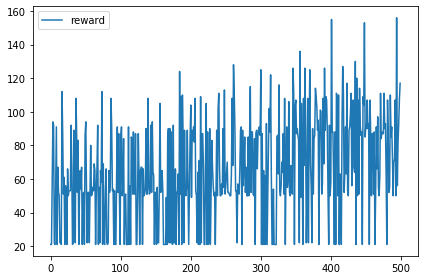

In [11]:
os.makedirs(model_path, exist_ok=True)

step = 0
generation = 0
total_rewards = []
for episode in range(n_episodes):
    obs = env.reset()
    total_reward = 0

    while True:
        # ε-greedyで行動を選択
        action = net.act(obs.float().to(device), epsilon_func(step))
        # 環境中で実際に行動
        next_obs, reward, done, info = env.step(make_action(action))
        total_reward += reward

        # リプレイバッファに経験を蓄積
        replay_buffer.push([obs, action, reward, next_obs, done])
        obs = next_obs

        # ネットワークを更新            
        if len(replay_buffer) > initial_buffer_size:
            update(batch_size, beta_func(step))

        # ターゲットネットワークを定期的に同期させる
        if (step + 1) % target_update_interval == 0:
            target_net.load_state_dict(net.state_dict())
        
        step += 1
        
        if done or info["time"] <= time_limit:
            break

    total_rewards.append(total_reward)
    print(f"Episode: {episode+1}, Step: {step}, Reward: {total_reward}")
    
    if episode % 10 == 0:
        torch.save(net.state_dict(), os.path.join(model_path, f"dqn_agent_gen_{generation}.pt"))
        generation += 1

plt.plot(total_rewards, label="reward")
plt.legend()
plt.tight_layout()

Episode: 501, Step: 38211, Reward: 104.0
Episode: 502, Step: 38290, Reward: 64.0
Episode: 503, Step: 38430, Reward: 114.0
Episode: 504, Step: 38548, Reward: 91.0
Episode: 505, Step: 38631, Reward: 83.0
Episode: 506, Step: 38692, Reward: 56.0
Episode: 507, Step: 38742, Reward: 50.0
Episode: 508, Step: 38852, Reward: 106.0
Episode: 509, Step: 38956, Reward: 95.0
Episode: 510, Step: 39007, Reward: 51.0
Episode: 511, Step: 39088, Reward: 81.0
Episode: 512, Step: 39174, Reward: 86.0
Episode: 513, Step: 39372, Reward: 156.0
Episode: 514, Step: 39459, Reward: 82.0
Episode: 515, Step: 39509, Reward: 50.0
Episode: 516, Step: 39630, Reward: 110.0
Episode: 517, Step: 39720, Reward: 68.0
Episode: 518, Step: 39881, Reward: 152.0
Episode: 519, Step: 40004, Reward: 107.0
Episode: 520, Step: 40121, Reward: 115.0
Episode: 521, Step: 40238, Reward: 110.0
Episode: 522, Step: 40323, Reward: 69.0
Episode: 523, Step: 40397, Reward: 65.0
Episode: 524, Step: 40494, Reward: 65.0
Episode: 525, Step: 40585, Rewa

Episode: 703, Step: 67966, Reward: 114.0
Episode: 704, Step: 68116, Reward: 109.0
Episode: 705, Step: 68224, Reward: 65.0
Episode: 706, Step: 68350, Reward: 122.0
Episode: 707, Step: 68429, Reward: 51.0
Episode: 708, Step: 68546, Reward: 114.0
Episode: 709, Step: 68671, Reward: 122.0
Episode: 710, Step: 68832, Reward: 156.0
Episode: 711, Step: 68990, Reward: 154.0
Episode: 712, Step: 69041, Reward: 51.0
Episode: 713, Step: 69092, Reward: 51.0
Episode: 714, Step: 69576, Reward: 185.0
Episode: 715, Step: 69681, Reward: 105.0
Episode: 716, Step: 69766, Reward: 68.0
Episode: 717, Step: 69856, Reward: 72.0
Episode: 718, Step: 70354, Reward: 191.0
Episode: 719, Step: 70435, Reward: 66.0
Episode: 720, Step: 70823, Reward: 200.0
Episode: 721, Step: 71307, Reward: 182.0
Episode: 722, Step: 71461, Reward: 149.0
Episode: 723, Step: 71961, Reward: 171.0
Episode: 724, Step: 72065, Reward: 104.0
Episode: 725, Step: 72214, Reward: 146.0
Episode: 726, Step: 72330, Reward: 114.0
Episode: 727, Step: 728

Episode: 903, Step: 113129, Reward: 193.0
Episode: 904, Step: 113368, Reward: 198.0
Episode: 905, Step: 113506, Reward: 134.0
Episode: 906, Step: 113654, Reward: 146.0
Episode: 907, Step: 113803, Reward: 147.0
Episode: 908, Step: 114229, Reward: 199.0
Episode: 909, Step: 114383, Reward: 148.0
Episode: 910, Step: 114548, Reward: 153.0
Episode: 911, Step: 114685, Reward: 137.0
Episode: 912, Step: 114838, Reward: 151.0
Episode: 913, Step: 115052, Reward: 195.0
Episode: 914, Step: 115550, Reward: 221.0
Episode: 915, Step: 115639, Reward: 89.0
Episode: 916, Step: 115765, Reward: 126.0
Episode: 917, Step: 115878, Reward: 113.0
Episode: 918, Step: 116014, Reward: 136.0
Episode: 919, Step: 116161, Reward: 147.0
Episode: 920, Step: 116312, Reward: 151.0
Episode: 921, Step: 116418, Reward: 106.0
Episode: 922, Step: 116502, Reward: 68.0
Episode: 923, Step: 116585, Reward: 66.0
Episode: 924, Step: 117007, Reward: 192.0
Episode: 925, Step: 117138, Reward: 131.0
Episode: 926, Step: 117252, Reward: 1

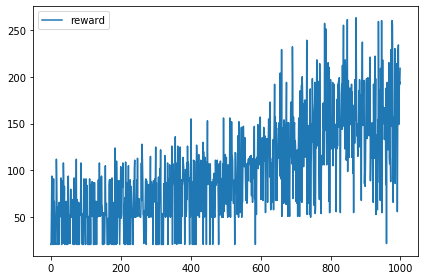

In [13]:
for episode in range(n_episodes, n_episodes*2):
    obs = env.reset()
    total_reward = 0

    while True:
        # ε-greedyで行動を選択
        action = net.act(obs.float().to(device), epsilon_func(step))
        # 環境中で実際に行動
        next_obs, reward, done, info = env.step(make_action(action))
        total_reward += reward

        # リプレイバッファに経験を蓄積
        replay_buffer.push([obs, action, reward, next_obs, done])
        obs = next_obs

        # ネットワークを更新            
        if len(replay_buffer) > initial_buffer_size:
            update(batch_size, beta_func(step))

        # ターゲットネットワークを定期的に同期させる
        if (step + 1) % target_update_interval == 0:
            target_net.load_state_dict(net.state_dict())
        
        step += 1
        
        if done or info["time"] <= time_limit:
            break

    total_rewards.append(total_reward)
    print(f"Episode: {episode+1}, Step: {step}, Reward: {total_reward}")
    
    if episode % 10 == 0:
        torch.save(net.state_dict(), os.path.join(model_path, f"dqn_agent_gen_{generation}.pt"))
        generation += 1

plt.plot(total_rewards, label="reward")
plt.legend()
plt.tight_layout()

Episode: 1001, Step: 135966, Reward: 112.0
Episode: 1002, Step: 136019, Reward: 53.0
Episode: 1003, Step: 136072, Reward: 53.0
Episode: 1004, Step: 136125, Reward: 53.0
Episode: 1005, Step: 136178, Reward: 53.0
Episode: 1006, Step: 136595, Reward: 201.0
Episode: 1007, Step: 136751, Reward: 153.0
Episode: 1008, Step: 137143, Reward: 198.0
Episode: 1009, Step: 137285, Reward: 137.0
Episode: 1010, Step: 137571, Reward: 188.0
Episode: 1011, Step: 137656, Reward: 68.0
Episode: 1012, Step: 137802, Reward: 135.0
Episode: 1013, Step: 138178, Reward: 255.0
Episode: 1014, Step: 138329, Reward: 151.0
Episode: 1015, Step: 138827, Reward: 186.0
Episode: 1016, Step: 138962, Reward: 135.0
Episode: 1017, Step: 139109, Reward: 147.0
Episode: 1018, Step: 139593, Reward: 179.0
Episode: 1019, Step: 139761, Reward: 150.0
Episode: 1020, Step: 139864, Reward: 88.0
Episode: 1021, Step: 140011, Reward: 147.0
Episode: 1022, Step: 140064, Reward: 53.0
Episode: 1023, Step: 140117, Reward: 53.0
Episode: 1024, Step

Episode: 1193, Step: 177001, Reward: 136.0
Episode: 1194, Step: 177132, Reward: 131.0
Episode: 1195, Step: 177279, Reward: 147.0
Episode: 1196, Step: 177667, Reward: 257.0
Episode: 1197, Step: 177780, Reward: 113.0
Episode: 1198, Step: 177935, Reward: 146.0
Episode: 1199, Step: 178424, Reward: 237.0
Episode: 1200, Step: 178578, Reward: 153.0
Episode: 1201, Step: 178778, Reward: 194.0
Episode: 1202, Step: 178903, Reward: 124.0
Episode: 1203, Step: 179231, Reward: 188.0
Episode: 1204, Step: 179646, Reward: 190.0
Episode: 1205, Step: 179785, Reward: 134.0
Episode: 1206, Step: 179932, Reward: 147.0
Episode: 1207, Step: 180416, Reward: 172.0
Episode: 1208, Step: 180547, Reward: 131.0
Episode: 1209, Step: 180694, Reward: 147.0
Episode: 1210, Step: 180982, Reward: 252.0
Episode: 1211, Step: 181225, Reward: 191.0
Episode: 1212, Step: 181508, Reward: 257.0
Episode: 1213, Step: 181655, Reward: 147.0
Episode: 1214, Step: 181851, Reward: 190.0
Episode: 1215, Step: 181976, Reward: 124.0
Episode: 12

Episode: 1384, Step: 225886, Reward: 54.0
Episode: 1385, Step: 226081, Reward: 190.0
Episode: 1386, Step: 226131, Reward: 50.0
Episode: 1387, Step: 226278, Reward: 147.0
Episode: 1388, Step: 226417, Reward: 137.0
Episode: 1389, Step: 226901, Reward: 185.0
Episode: 1390, Step: 227381, Reward: 254.0
Episode: 1391, Step: 227515, Reward: 134.0
Episode: 1392, Step: 227986, Reward: 232.0
Episode: 1393, Step: 228484, Reward: 230.0
Episode: 1394, Step: 228539, Reward: 52.0
Episode: 1395, Step: 228704, Reward: 158.0
Episode: 1396, Step: 228871, Reward: 158.0
Episode: 1397, Step: 229003, Reward: 125.0
Episode: 1398, Step: 229096, Reward: 70.0
Episode: 1399, Step: 229246, Reward: 149.0
Episode: 1400, Step: 229300, Reward: 54.0
Episode: 1401, Step: 229423, Reward: 118.0
Episode: 1402, Step: 229546, Reward: 117.0
Episode: 1403, Step: 230030, Reward: 172.0
Episode: 1404, Step: 230510, Reward: 237.0
Episode: 1405, Step: 230636, Reward: 107.0
Episode: 1406, Step: 230982, Reward: 257.0
Episode: 1407, S

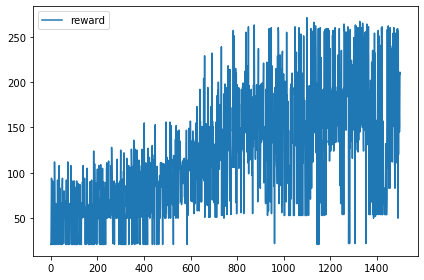

In [15]:
for episode in range(n_episodes*2, n_episodes*3):
    obs = env.reset()
    total_reward = 0

    while True:
        # ε-greedyで行動を選択
        action = net.act(obs.float().to(device), epsilon_func(step))
        # 環境中で実際に行動
        next_obs, reward, done, info = env.step(make_action(action))
        total_reward += reward

        # リプレイバッファに経験を蓄積
        replay_buffer.push([obs, action, reward, next_obs, done])
        obs = next_obs

        # ネットワークを更新            
        if len(replay_buffer) > initial_buffer_size:
            update(batch_size, beta_func(step))

        # ターゲットネットワークを定期的に同期させる
        if (step + 1) % target_update_interval == 0:
            target_net.load_state_dict(net.state_dict())
        
        step += 1
        
        if done or info["time"] <= time_limit:
            break

    total_rewards.append(total_reward)
    print(f"Episode: {episode+1}, Step: {step}, Reward: {total_reward}")
    
    if episode % 10 == 0:
        torch.save(net.state_dict(), os.path.join(model_path, f"dqn_agent_gen_{generation}.pt"))
        generation += 1

plt.plot(total_rewards, label="reward")
plt.legend()
plt.tight_layout()

In [ ]:
for episode in range(n_episodes*3, n_episodes*4):
    obs = env.reset()
    total_reward = 0

    while True:
        # ε-greedyで行動を選択
        action = net.act(obs.float().to(device), epsilon_func(step))
        # 環境中で実際に行動
        next_obs, reward, done, info = env.step(make_action(action))
        total_reward += reward

        # リプレイバッファに経験を蓄積
        replay_buffer.push([obs, action, reward, next_obs, done])
        obs = next_obs

        # ネットワークを更新            
        if len(replay_buffer) > initial_buffer_size:
            update(batch_size, beta_func(step))

        # ターゲットネットワークを定期的に同期させる
        if (step + 1) % target_update_interval == 0:
            target_net.load_state_dict(net.state_dict())
        
        step += 1
        
        if done or info["time"] <= time_limit:
            break

    total_rewards.append(total_reward)
    print(f"Episode: {episode+1}, Step: {step}, Reward: {total_reward}")
    
    if episode % 10 == 0:
        torch.save(net.state_dict(), os.path.join(model_path, f"dqn_agent_gen_{generation}.pt"))
        generation += 1

plt.plot(total_rewards, label="reward")
plt.legend()
plt.tight_layout()

Episode: 1501, Step: 251931, Reward: 255.0
Episode: 1502, Step: 252060, Reward: 129.0
Episode: 1503, Step: 252180, Reward: 120.0
Episode: 1504, Step: 252300, Reward: 120.0
Episode: 1505, Step: 252521, Reward: 210.0
Episode: 1506, Step: 253019, Reward: 228.0
Episode: 1507, Step: 253516, Reward: 163.0
Episode: 1508, Step: 253678, Reward: 158.0
Episode: 1509, Step: 254162, Reward: 230.0
Episode: 1510, Step: 254642, Reward: 253.0
Episode: 1511, Step: 254754, Reward: 112.0
Episode: 1512, Step: 255225, Reward: 164.0
Episode: 1513, Step: 255336, Reward: 111.0
Episode: 1514, Step: 255633, Reward: 255.0
Episode: 1515, Step: 256122, Reward: 181.0
Episode: 1516, Step: 256251, Reward: 129.0
Episode: 1517, Step: 256731, Reward: 248.0
Episode: 1518, Step: 257231, Reward: 183.0
Episode: 1519, Step: 257702, Reward: 238.0
Episode: 1520, Step: 257917, Reward: 213.0
Episode: 1521, Step: 258058, Reward: 141.0
Episode: 1522, Step: 258547, Reward: 228.0
Episode: 1523, Step: 258762, Reward: 188.0
Episode: 15

In [50]:
def valid():
    
    agent = CNNQNetwork(env.observation_space.shape, n_action=2).to(device)
    state_dict = torch.load("models/dqn_agent_gen_120.pt")
    agent.load_state_dict(state_dict)
    
    for episode in range(5):
        obs_ = env.reset()

        step_ = 0
        done_ = False
        while not done_:           
            action_ = agent.act(obs_.float().to(device), epsilon=0.0)
            next_obs_, reward_, done_, _ = env.step(make_action(action_))
            obs_ = next_obs_
            step_ += 1
            
            #controller = "→" if action_ == 0 else "→A"
            #text = f"Step: {step_} Action: {controller}"
            #print(f"\r{text}", end="")
    
        #print(f"\r{'Finished'}", end="")
    
valid()

KeyboardInterrupt: 